In [1]:
"""Import the required modules"""
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import timeit

Analyzing welding data by welding types

In [2]:
df2 = pd.read_csv('welding_data_by_welding_types.csv')
df2 = pd.get_dummies(df2).drop('welding_type_GMAW', axis=1)
df2 = df2[['current', 'voltage', 'welding_speed', 'plate_thickness',	'welding_type_SAW',	'welding_type_SMAW',	              'welding_type_GTAW', 'heat_input', 'flexural_strength', 'hardness_value', 'residual_stress',
           'tensile_strength']]
df2.head()

,current,voltage,welding_speed,plate_thickness,welding_type_SAW,welding_type_SMAW,welding_type_GTAW,heat_input,flexural_strength,hardness_value,residual_stress,tensile_strength
0,160,32,120,6,0,0,1,1536,236.2,102.5,152.0,432.6
1,130,32,90,8,0,1,0,2218,270.2,96.4,270.2,332.8
2,100,28,120,8,0,0,1,840,360.8,86.4,90.5,382.4
3,160,28,90,10,0,0,1,1792,230.0,105.0,165.4,422.8
4,100,28,120,8,1,0,0,1400,276.5,128.4,186.6,385.5


Exploratory data analysis

In [3]:
# pos = 1
# for i in range(4):
#   print(f'\t{df2.columns[i].capitalize()} vs Response values')
#   plt.figure()
#   for j in range(8, 11):
#     plt.subplot(1, 3, pos)
#     plt.scatter(df2.iloc[:, i], df2.iloc[:, j])
#     plt.ylabel(df2.columns[j])
#     plt.xlabel(df2.columns[i])
#     pos += 1
#   plt.tight_layout()
#   plt.show()
#   print('\n')
#   pos = 1

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.


Generate the necessary variables for modeling

In [4]:
X1 = df2.iloc[:, :7]
X = X1.to_numpy()
y1 = df2.iloc[:, -5:]
y = y1.to_numpy()

In [5]:
def MAD(y, y_pred):
    '''Calculates the Mean Absolute Deviation of two arrays of numbers
    Input: y(array), y_pred(array)
    Output: float
    '''
    import numpy as np

    return np.average(np.abs(y - y_pred))

In [6]:
def MAPE(y, y_pred):
    '''
    Calculates the relationship between the average prediction error
    and the average expected target error for several consecutive periods.

    Input: y(array), y_pred(array)
    Output: float
    '''
    import numpy as np

    # Calculate prediction error
    error = y - y_pred

    return np.average((np.abs(error)/y) * 100)

In [7]:
def TS(y, y_pred):
    '''
    This index is used to track the accuracy of the model

    Input: y(array), y_pred(array)
    Output: float
    '''
    import numpy as np

    def MAD(y, y_pred):
        '''Calculates the Mean Absolute Deviation of two arrays of numbers
        Input: y(array), y_pred(array)
        Output: float
        '''
        return np.average(np.abs(y - y_pred))

    return np.sum(y - y_pred) / MAD(y, y_pred)

In [8]:
def split_name(name, char='_'):
    index = name.find(char)
    return name[:index].capitalize() + ' ' + name[index+1:].capitalize()

Predicting individual response separately to optimize prediction


heat_input: 5 Nodes


,Expected,Predicted
0,1120.0,985.800502
1,1280.0,1079.316317
2,960.0,956.633299
3,1792.0,1579.711843
4,1024.0,1192.763313
5,2048.0,1812.762410
6,936.0,887.439344
7,768.0,723.393863


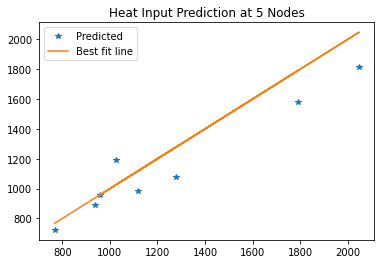


flexural_strength: 5 Nodes


,Expected,Predicted
0,218.4,208.807947
1,238.4,264.608545
2,336.8,346.775239
3,230.0,351.959797
4,196.0,177.656781
5,260.0,250.257094
6,345.0,350.207303
7,394.4,380.132690


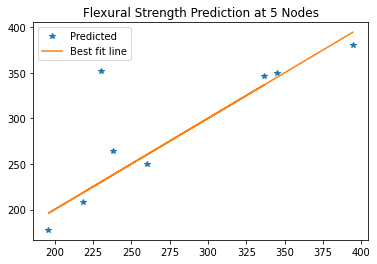


hardness_value: 5 Nodes


,Expected,Predicted
0,132.5,112.953520
1,116.2,163.844554
2,90.6,81.929717
3,105.0,119.179114
4,142.2,154.795674
5,110.0,50.752494
6,80.5,62.472672
7,65.0,96.587521


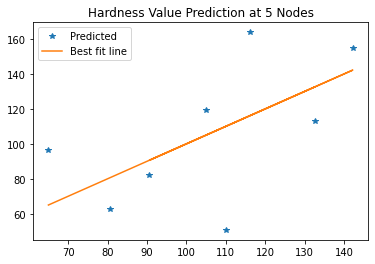


residual_stress: 5 Nodes


,Expected,Predicted
0,188.6,174.072136
1,216.8,224.129451
2,125.8,125.512460
3,165.4,180.022517
4,164.0,136.457019
5,264.6,266.350213
6,108.6,121.564304
7,82.0,114.857315


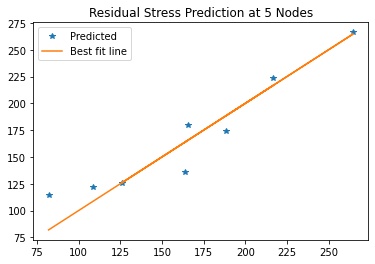


tensile_strength: 5 Nodes


,Expected,Predicted
0,312.8,407.267516
1,442.6,322.868910
2,396.5,452.516336
3,422.8,394.863919
4,280.2,282.844811
5,304.2,158.823106
6,394.6,418.443864
7,378.5,349.427405


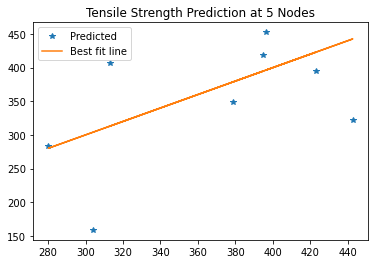


heat_input: 10 Nodes


,Expected,Predicted
0,1120.0,951.234503
1,1280.0,1137.423744
2,960.0,1030.590802
3,1792.0,1768.625037
4,1024.0,1214.750860
5,2048.0,2102.556407
6,936.0,876.636582
7,768.0,725.816052


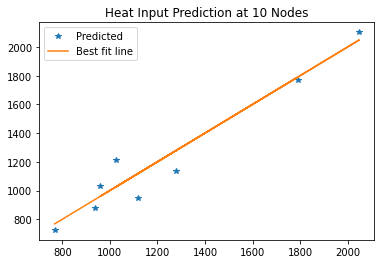


flexural_strength: 10 Nodes


,Expected,Predicted
0,218.4,236.528861
1,238.4,184.452906
2,336.8,352.386225
3,230.0,373.228127
4,196.0,205.033233
5,260.0,167.738080
6,345.0,331.891625
7,394.4,362.065480


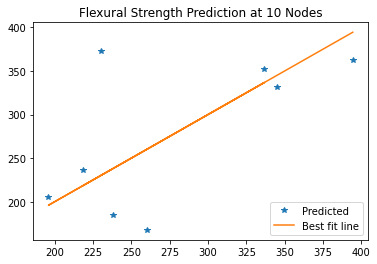


hardness_value: 10 Nodes


,Expected,Predicted
0,132.5,134.012047
1,116.2,117.382021
2,90.6,78.536574
3,105.0,79.153313
4,142.2,112.442014
5,110.0,86.388199
6,80.5,115.051329
7,65.0,115.576171


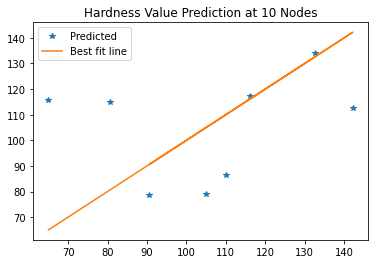


residual_stress: 10 Nodes


,Expected,Predicted
0,188.6,169.525614
1,216.8,174.140706
2,125.8,141.760323
3,165.4,116.528131
4,164.0,178.033274
5,264.6,235.196075
6,108.6,89.236024
7,82.0,67.488839


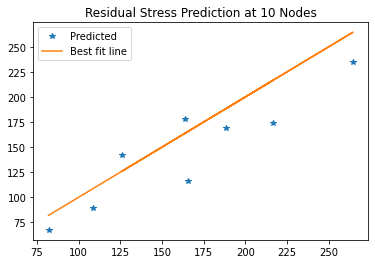


tensile_strength: 10 Nodes


,Expected,Predicted
0,312.8,354.250937
1,442.6,374.269330
2,396.5,454.833334
3,422.8,369.346111
4,280.2,274.989461
5,304.2,246.253271
6,394.6,414.991652
7,378.5,322.195545


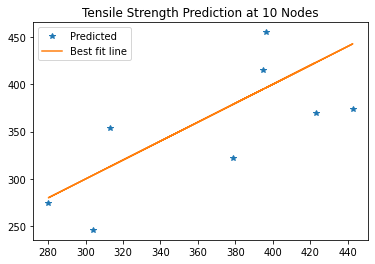


heat_input: 15 Nodes


,Expected,Predicted
0,1120.0,958.258088
1,1280.0,1448.703862
2,960.0,999.737364
3,1792.0,2018.733219
4,1024.0,989.297527
5,2048.0,1818.659212
6,936.0,939.505783
7,768.0,905.724220


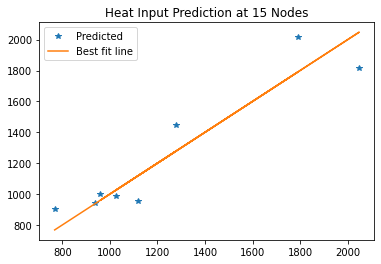


flexural_strength: 15 Nodes


,Expected,Predicted
0,218.4,210.579422
1,238.4,253.869916
2,336.8,363.236924
3,230.0,247.856446
4,196.0,179.278690
5,260.0,228.215588
6,345.0,337.476745
7,394.4,358.882137


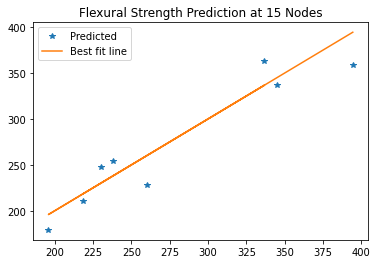


hardness_value: 15 Nodes


,Expected,Predicted
0,132.5,110.651404
1,116.2,139.316714
2,90.6,76.200522
3,105.0,101.762078
4,142.2,154.468737
5,110.0,108.376818
6,80.5,88.358441
7,65.0,104.939292


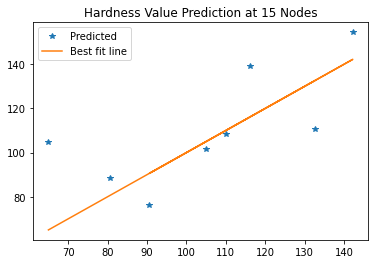


residual_stress: 15 Nodes


,Expected,Predicted
0,188.6,174.332198
1,216.8,231.470373
2,125.8,109.053765
3,165.4,194.965176
4,164.0,155.720058
5,264.6,225.816613
6,108.6,107.186865
7,82.0,111.148894


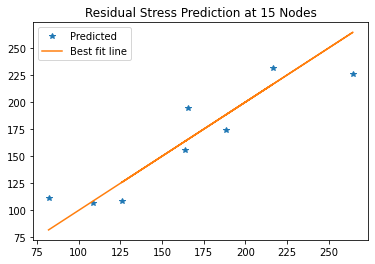


tensile_strength: 15 Nodes


,Expected,Predicted
0,312.8,339.301624
1,442.6,394.022368
2,396.5,463.884463
3,422.8,396.395342
4,280.2,226.522055
5,304.2,288.696434
6,394.6,431.414405
7,378.5,332.738303


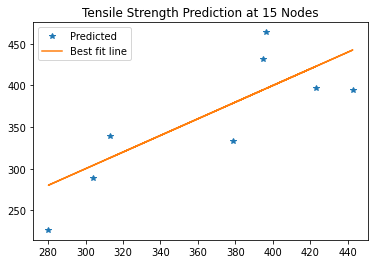


heat_input: 20 Nodes


,Expected,Predicted
0,1120.0,943.595009
1,1280.0,1406.080440
2,960.0,1299.799723
3,1792.0,1690.915976
4,1024.0,1101.176663
5,2048.0,1997.640126
6,936.0,925.543030
7,768.0,656.029634


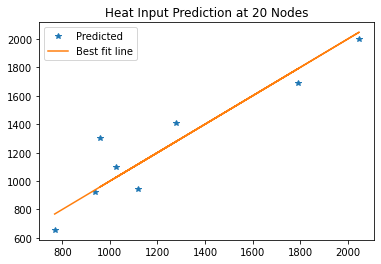


flexural_strength: 20 Nodes


,Expected,Predicted
0,218.4,177.941577
1,238.4,278.965153
2,336.8,416.486637
3,230.0,244.264311
4,196.0,181.079701
5,260.0,264.113617
6,345.0,314.601119
7,394.4,343.755778


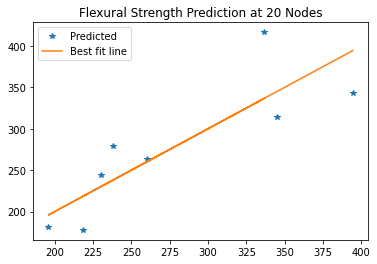


hardness_value: 20 Nodes


,Expected,Predicted
0,132.5,108.643879
1,116.2,153.206612
2,90.6,110.355986
3,105.0,82.777107
4,142.2,126.965290
5,110.0,119.745434
6,80.5,107.344081
7,65.0,90.921246


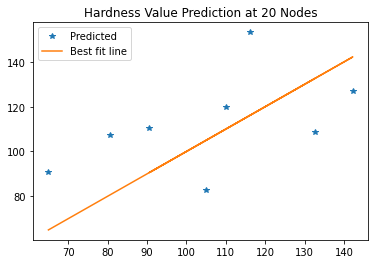


residual_stress: 20 Nodes


,Expected,Predicted
0,188.6,153.353656
1,216.8,232.034377
2,125.8,157.064123
3,165.4,158.924944
4,164.0,164.853742
5,264.6,264.528693
6,108.6,125.963791
7,82.0,95.038157


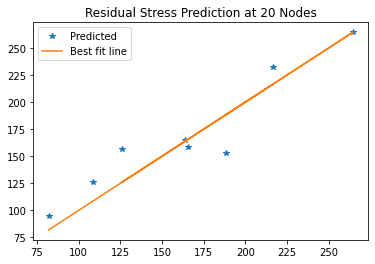


tensile_strength: 20 Nodes


,Expected,Predicted
0,312.8,309.747755
1,442.6,418.853315
2,396.5,504.510434
3,422.8,381.071155
4,280.2,238.129906
5,304.2,301.973532
6,394.6,400.980752
7,378.5,310.951798


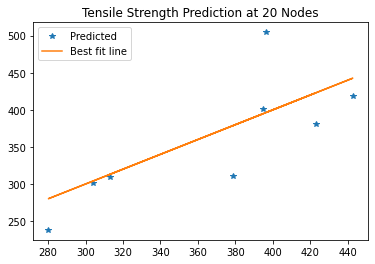


heat_input: 25 Nodes


,Expected,Predicted
0,1120.0,901.445565
1,1280.0,1381.594987
2,960.0,867.675133
3,1792.0,1825.752927
4,1024.0,1033.555082
5,2048.0,1827.558837
6,936.0,884.921418
7,768.0,884.093205


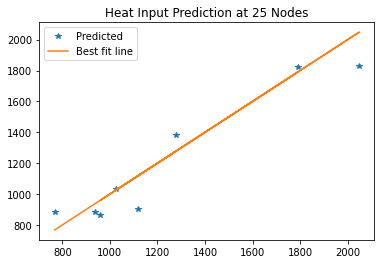


flexural_strength: 25 Nodes


,Expected,Predicted
0,218.4,197.783091
1,238.4,273.296857
2,336.8,379.037326
3,230.0,245.908163
4,196.0,179.777445
5,260.0,272.647281
6,345.0,285.125923
7,394.4,377.609718


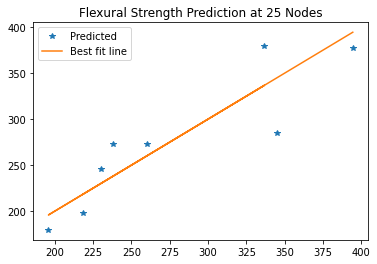


hardness_value: 25 Nodes


,Expected,Predicted
0,132.5,111.936465
1,116.2,152.371594
2,90.6,98.020284
3,105.0,95.042899
4,142.2,141.131436
5,110.0,106.470374
6,80.5,101.057304
7,65.0,118.744961


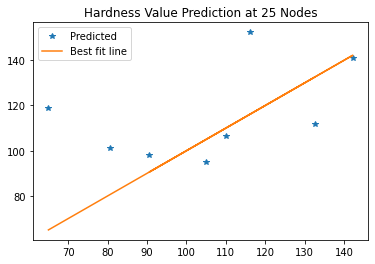


residual_stress: 25 Nodes


,Expected,Predicted
0,188.6,155.138134
1,216.8,224.879571
2,125.8,118.678594
3,165.4,175.694023
4,164.0,155.930113
5,264.6,262.640918
6,108.6,115.475907
7,82.0,103.555191


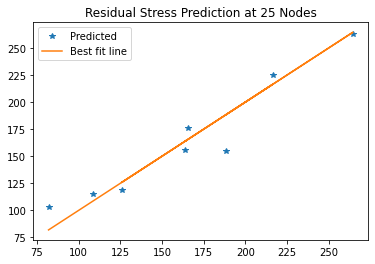


tensile_strength: 25 Nodes


,Expected,Predicted
0,312.8,326.254800
1,442.6,450.025604
2,396.5,481.912177
3,422.8,330.593531
4,280.2,272.931525
5,304.2,290.507299
6,394.6,370.786751
7,378.5,373.826367


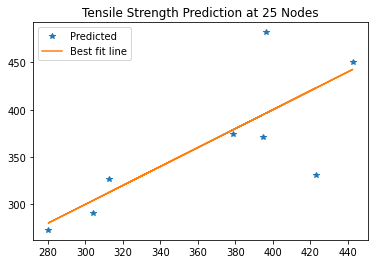


heat_input: 30 Nodes


,Expected,Predicted
0,1120.0,888.624462
1,1280.0,1292.004984
2,960.0,1057.019087
3,1792.0,1847.579030
4,1024.0,1096.192093
5,2048.0,2053.134690
6,936.0,966.580172
7,768.0,849.155002


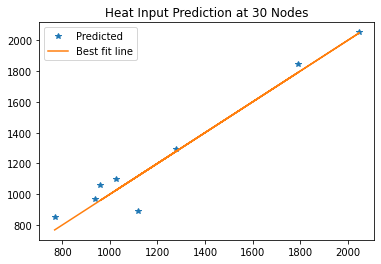


flexural_strength: 30 Nodes


,Expected,Predicted
0,218.4,208.993423
1,238.4,246.498159
2,336.8,406.740883
3,230.0,269.746901
4,196.0,214.556657
5,260.0,247.661478
6,345.0,323.756511
7,394.4,344.516581


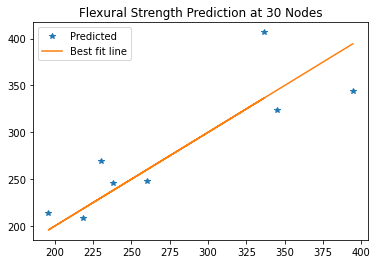


hardness_value: 30 Nodes


,Expected,Predicted
0,132.5,111.798570
1,116.2,127.314185
2,90.6,91.239540
3,105.0,98.768302
4,142.2,159.170803
5,110.0,115.307935
6,80.5,105.133028
7,65.0,109.350488


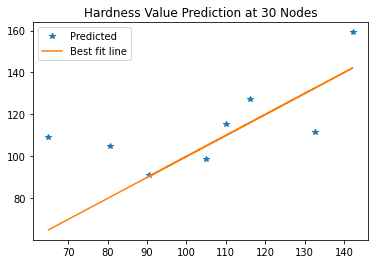


residual_stress: 30 Nodes


,Expected,Predicted
0,188.6,156.985873
1,216.8,212.847557
2,125.8,128.405973
3,165.4,196.872684
4,164.0,180.610224
5,264.6,252.327441
6,108.6,131.782025
7,82.0,105.411618


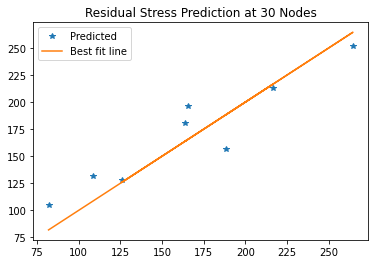


tensile_strength: 30 Nodes


,Expected,Predicted
0,312.8,337.699368
1,442.6,392.608480
2,396.5,475.268363
3,422.8,370.654566
4,280.2,323.945980
5,304.2,326.067221
6,394.6,421.628330
7,378.5,354.826004


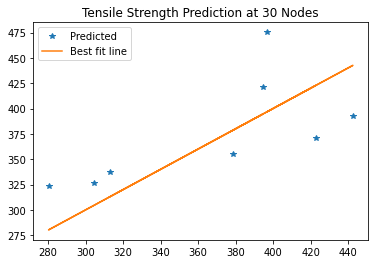

,Variable,Nodes,R2,MSE,RMSE,MAD,MAPE,TS,Time
0,heat_input,5,0.797535,23940.833315,154.728256,130.963217,9.852605,5.422737,0.036292
1,flexural_strength,5,0.592031,2051.832852,45.297162,26.912047,11.200768,-4.139611,0.039418
2,hardness_value,5,0.314893,989.995435,31.464193,26.437307,26.567187,-0.019490,0.066528
3,residual_stress,5,0.880297,311.004468,17.635319,13.985273,11.202067,-1.942430,0.063307
4,tensile_strength,5,0.201209,6216.635240,78.845642,62.386148,17.555603,2.326544,0.012787
5,heat_input,10,0.936400,12375.628162,111.245801,94.020269,8.498948,1.280213,0.000269
6,flexural_strength,10,0.356191,4225.922908,65.007099,47.203544,18.740312,0.120234,0.020019
7,hardness_value,10,-1.018974,751.507399,27.413635,22.387683,25.401482,0.154475,0.065524
8,residual_stress,10,0.685706,809.237495,28.447100,25.484776,15.902721,5.646156,0.015094
9,tensile_strength,10,0.411618,2452.292621,49.520628,45.177776,12.124597,2.679865,0.014578


In [9]:
metrics = []
for h in range(5, 35, 5):
  for i in range(y.shape[1]):
    metric = [y1.columns[i], int(h)]
    cols = y[:, i]
    X_train, X_test, y_train, y_test = train_test_split(X, cols,random_state=1, test_size=0.2)

    tic = timeit.timeit() #Start timer
    sc_X = StandardScaler()
    X_trainscaled=sc_X.fit_transform(X_train)
    X_testscaled=sc_X.transform(X_test)
    reg = MLPRegressor(hidden_layer_sizes=(h,h,h),activation="relu" ,random_state=1, max_iter=1000000).fit(X_trainscaled, y_train)
    y_pred=reg.predict(X_testscaled)
    toc = timeit.timeit() #Stop timer

    # Display data
    print(f'\n{y1.columns[i]}: {int(h)} Nodes')
    a = []
    for j in range(len(y_test)):
        a.append([y_test[j], y_pred[j]])
    a_df = pd.DataFrame(a, columns=['Expected', 'Predicted'])

    # Display output
    display(a_df)
    plt.plot(y_test, y_pred, '*', label='Predicted')
    plt.plot(y_test, y_test, label='Best fit line')
    plt.title(f'{split_name(y1.columns[i])} Prediction at {int(h)} Nodes')
    plt.legend()
    plt.show()

    # Calculate the necessary metrics
    r2 = r2_score(y_pred, y_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mad = MAD(y_test, y_pred)
    mape = MAPE(y_test, y_pred)
    ts = TS(y_test, y_pred)
    time = abs(toc - tic)

    metric.extend([r2, mse, rmse, mad, mape, ts, time])   # Update metric
    metrics.append(metric)  # Undate metrics

metrics_df = pd.DataFrame(metrics, columns=['Variable', 'Nodes', 'R2', 'MSE', 'RMSE', 'MAD', 'MAPE', 'TS', 'Time'])

display(metrics_df)